In [1]:
from download import *
from databuilder import *
from dataset import *
from processing import *

df = download_mimii("../../data/mimii", "0_dB")

../../data/mimii/0_dB/fan.zip already exist.
../../data/mimii/0_dB/fan.zip already extracted.
../../data/mimii/0_dB/pump.zip already exist.
../../data/mimii/0_dB/pump.zip already extracted.
../../data/mimii/0_dB/slider.zip already exist.
../../data/mimii/0_dB/slider.zip already extracted.
../../data/mimii/0_dB/valve.zip already exist.
../../data/mimii/0_dB/valve.zip already extracted.


In [2]:
params = {
    "batch_size":32,
    "epoch": 5,
    "learning_rate": 0.0001,
    "path": "./saved/epoch900/"
}

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [3]:
# df["label"].value_counts()
df["label"].value_counts().sort_index()

0    14719
1     1475
2      456
3      890
4      479
Name: label, dtype: int64

In [4]:
train_df, val_df, test_df = split_dataframe(df, 0.6, 0.2)
# print(train_df.shape)
# print(val_df.shape)
# print(test_df.shape)

In [5]:
train_data, train_label = build_from_dataframe(train_df, 4096, 4096//2, False)
val_data, val_label = build_from_dataframe(val_df, 4096, 4096//2, False)
test_data, test_label = build_from_dataframe(test_df, 4096, 4096//2, False)
# print(train_data.shape)
# print(train_data)

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    melspectogram(),
    ExpandDim(),
    ReSize(3, 32, 32),
    NpToTensor()
])

In [7]:
train_dataset = NumpyDataset(data=train_data, label=train_label, 
                             transform=transform, target_transform=NpToTensor())
val_dataset = NumpyDataset(data=val_data, label=val_label, 
                             transform=transform, target_transform=NpToTensor())
test_dataset = NumpyDataset(data=test_data, label=test_label, 
                             transform=transform, target_transform=NpToTensor())

print(train_dataset.data)
print(train_dataset.label)
print(train_dataset.data.shape)

[[ 2.0599365e-03  4.4326782e-03  6.5078735e-03 ... -1.8882751e-03
  -2.3345947e-03 -3.1280518e-03]
 [ 2.9563904e-03  2.5138855e-03  3.0975342e-03 ...  9.1590881e-03
   7.2135925e-03  7.3356628e-03]
 [-1.4266968e-03 -3.8146973e-06  8.0108643e-05 ... -6.1149597e-03
  -5.3596497e-03 -4.7531128e-03]
 ...
 [-3.4980774e-03 -4.1923523e-03 -4.1732788e-03 ...  2.0599365e-04
   1.0643005e-03  1.0108948e-03]
 [ 4.0817261e-04  2.6969910e-03  4.2304993e-03 ...  5.8746338e-03
   4.3945312e-03  3.4751892e-03]
 [ 5.8364868e-04  3.0899048e-04  3.0899048e-04 ... -4.6539307e-04
  -5.0735474e-04 -5.4550171e-04]]
[1. 1. 1. ... 0. 0. 0.]
(810855, 4096)


In [8]:
train_loader = get_dataloader(dataset=train_dataset,
                              batch_size=params["batch_size"],
                              shuffle=True)
val_loader = get_dataloader(dataset=val_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)
test_loader = get_dataloader(dataset=test_dataset,
                              batch_size=params["batch_size"],
                              shuffle=False)

In [9]:
for i, (data, target) in enumerate(train_loader):
    print(i, data.shape, target.shape, data[0].shape)
    if i > 9:
        break

0 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
1 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
2 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
3 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
4 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
5 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
6 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
7 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
8 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
9 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])
10 torch.Size([32, 3, 32, 32]) torch.Size([32]) torch.Size([3, 32, 32])


In [10]:
#train()
def train(model, train_loader, optimizer, device, criterion, epoch, batch_size):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        prediction = output.max(1, keepdim = True)[1]
        correct += prediction.eq(label.view_as(prediction)).sum().item()

    train_loss /= (len(train_loader.dataset) / batch_size)
    train_accuracy = correct / len(train_loader.dataset)
    return train_loss, train_accuracy
    
#test()
def test(model, test_loader, device, criterion, batch_size):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / batch_size)
    test_accuracy = correct / len(test_loader.dataset)
    return test_loss, test_accuracy


In [11]:
from ResNet import Model
import torch
from torchvision import transforms, datasets
import torch.nn as nn

# 이미지 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

In [12]:
model = Model().resnet18().to(DEVICE)
from torchvision import models
# model = models.resnet50().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [13]:
# train, test의 acc와 loss를 담을 리스트
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

# 학습 진행
for epoch in range(1, params["epoch"] + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, DEVICE, criterion, epoch, batch_size=params["batch_size"])
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

    test_loss, test_accuracy = test(model, test_loader, DEVICE, criterion, batch_size=params["batch_size"])
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print("[EPOCH: {}] \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f}\n".format(
        epoch, test_loss, test_accuracy))
    # 에폭당 학습률 확인(필요시)
    # l_r = [x["lr"] for x in optimizer.param_groups]
    # print("lr:{}\n".format(l_r))

[EPOCH: 1] 	Train Loss: 0.3090, 	Train Accuracy: 0.9061
[EPOCH: 1] 	Test Loss: 0.3987, 	Test Accuracy: 0.8771

[EPOCH: 2] 	Train Loss: 0.1985, 	Train Accuracy: 0.9382
[EPOCH: 2] 	Test Loss: 0.2217, 	Test Accuracy: 0.9343

[EPOCH: 3] 	Train Loss: 0.1700, 	Train Accuracy: 0.9466
[EPOCH: 3] 	Test Loss: 0.2680, 	Test Accuracy: 0.9237

[EPOCH: 4] 	Train Loss: 0.1543, 	Train Accuracy: 0.9516
[EPOCH: 4] 	Test Loss: 0.3427, 	Test Accuracy: 0.8955

[EPOCH: 5] 	Train Loss: 0.1441, 	Train Accuracy: 0.9543
[EPOCH: 5] 	Test Loss: 0.2251, 	Test Accuracy: 0.9343



In [14]:
def DrawGraph(acc_list, loss_list, title, mode, root):
    '''
    acc_list: train acc list or test acc list
    loss_list: train loss list or test loss list
    title: 그래프 제목
    mode: train인지 valid인지
    path: 그림 저장할 경로
    '''

    if not os.path.isdir(root):
        os.makedirs(root)

    mode = mode.lower()
    valid_modes = ['train', 'test']
    if mode not in valid_modes:
        raise ValueError("Mode {} not supported, please use one of {}".format(mode, valid_modes))

    x = np.arange(len(acc_list))

    fig, ax1 = plt.subplots()
    ax1.plot(x, acc_list, label= mode+' acc', color='blue')
    ax1.set_ylabel('acc')
    ax2 = ax1.twinx()
    ax2.plot(x, loss_list, label= mode+' loss', color='yellow')
    ax2.set_ylabel('loss')
    ax1.set_xlabel('epochs')

    ax1.set_title(title)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2
    ax1.legend(lines, labels, loc="upper left")
    plt.savefig(f"{root}/{mode}.png")

max_test_acc:  0.9342836529694846


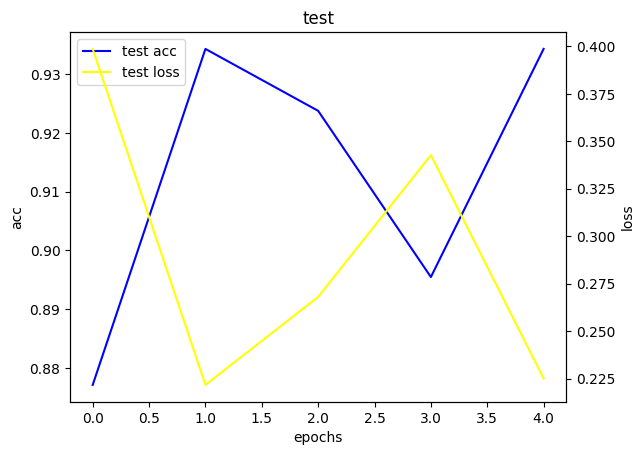

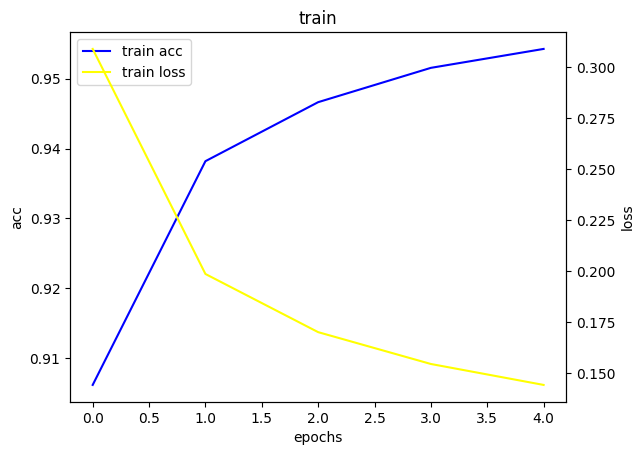

In [15]:
PATH = "./saved/resnet"
DrawGraph(test_acc_list, test_loss_list, 'test', mode='test', root = PATH)
DrawGraph(train_acc_list, train_loss_list, 'train', mode='train', root = PATH)

# 최대 test 정확도 출력
max_test_acc = max(test_acc_list)
print('max_test_acc: ', max_test_acc)

# 모델 저장
torch.save(model.state_dict(), f"{PATH}/model.pth")